In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pvlib

In [3]:
# where is Pechbusque...
# latitude, longitude, name, altitude, timezone

coordinates = [
    # (43.5, 1.47, 'Pechbusque', 270.0, 'Europe/Paris'),
    (43.58, 3.97, 'Montpellier', 6, 'Europe/Paris')
]

In [4]:
#-----------------------------------------------------------------------------------------------------
# données module Trina : sources = datasheet Trina, base CEC, autres info reprises de la db SAM
#-----------------------------------------------------------------------------------------------------

module_trina_vertex_405 = {
    "Vintage" : 2021,  # datasheet info
    "Area" : 1.91,
    "Material" : "Mono-c-Si", # datasheet info
    "Cells_in_Series" : 60, # CEC database info
    "Parallel_Strings" : 2, # CEC database info
    "Isco" : 12.34, # short circuit current : datasheet info
    "Voco" : 41.4, # open circuit voltage : datasheet info
    "Impo" : 11.77, # max power current : datasheet info
    "Vmpo" : 34.4, # max power voltage : datasheet info
    "Aisc" : 0.0004, # short circuit temperature coefficient : datasheet info plus pénalisante que CEC info
    "Aimp" : 0.0004, # maximum power temperature coefficient : inconnu, on reconduit Aisc
    "C0" : 1.01284, # coefficients relating Im p to G : ?
    "C1" : -0.01284, # coefficients relating Im p to G : ?
    "Bvoco" : -0.266, # open circuit temperature coefficient : CEC info plus pénalisante que datasheet info 
    "Mbvoc" : 0, # relates βoc,re f to effective irradiance : 0 ?
    "Bvmpo" : -0.266, # maximum power voltage temperature coefficient : inconnnu, on reconduit Bvoco
    "Mbvmp" : 0, # relates βm p,re f to effective irradiance : 0 ?
    "N" : 1.4032, # diode factor : ?
    "C2" : 0.279317, # coefficients relating Vm p to G : ?
    "C3" : -7.24463, # coefficients relating Vm p to G : ?
    "A0" : 0.928385, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A1" : 0.068093, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A2" : -0.015774, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A3" : 0.001661, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "A4" : -0.000069, # air mass coefficients 0...4 - spectral effects on Isc to the variation of air mass over the day - ?
    "B0" : 1, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B1" : -0.002438, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B2" : 0.00031, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B3" : -0.000012, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B4" : 0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "B5" : -0.0, # incidence angle modifier coefficients 0...5 - optical effects on Isc to the angle of incidence AOI (Section 5.1) - ?
    "DTC" : 3.0, # ??
    "FD" : 1, # fraction of diffuse irradiance used by module
    "A" : -3.40641, # ??
    "B" : -0.084208, # ??
    "C4" : 0.996446, # coefficients relating Ix to G : ?
    "C5" : 0.003554, # coefficients relating Ix to G : ?
    "IXO" : 4.97599, # ?
    "IXXO" : 3.18803, # ?
    "C6" : 1.15535, # coefficients relating Ixx to G : ?
    "C7" : -0.155353, # coefficients relating Ixx to G : ?
    "Notes" : "Format SAM model, Source: CEC database, 11-Aug-2022",
    "Name" : "Trina_Vertex_405Wc_TSM-DE09"
}

In [5]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur SMA Tripower Smart Energy --------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tripower_sme = {
    "Vac" : 230.0, # Nominal voltage,
    "Pso" : 44.0, # Power consumption during operation
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 12000.0, # Maximum DC power
    "Vdco" : 600.0, # Nominal DC voltage
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC
    "Pnt" : 0.075, # Inverter night time loss : ?
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 20.0, # Maximum DC current
    "Mppt_low" : 330.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [6]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur Référence : SMA Tripower 8.0 -----------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_sma_tri_ref_8kVA = {
    "Vac" : 480.0, # Nominal voltage, -- inchangé -- essai à 230 : non, essai à 380 neg ; essai à 480
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power - ok
    "Pdco" : 15000.0, # Maximum DC power - changé de 12000 à 15000
    "Vdco" : 580.0, # Nominal DC voltage - changé de 600 à 580
    "C0" : -7.06449e-07, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage -- ok
    "Idcmax" : 20.0, # Maximum DC current -- ok
    "Mppt_low" : 260.0, # min MPP voltage -- changé de 330 à 260
    "Mppt_high" : 800.0, # max MPP voltage -- inchangé
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [7]:
#-----------------------------------------------------------------------------------------------------
#--- Onduleur custom ---------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------

inverter_custom = {
    "Vac" : 380.0, # Nominal voltage, 
    "Pso" : 44.0, # Power consumption during operation -- inchangé
    "Paco" : 8000.0, # Maximum AC power
    "Pdco" : 15000.0, # Maximum DC power
    "Vdco" : 580.0, # Nominal DC voltage
    "C0" : -1e-6, # Curvature between AC power and DC power W−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C1" : -3.5e-05, # Coefficient of Pd c,0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C2" : -0.000328, # Coefficient of Pso variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "C3" : -0.001748, # Coefficient of C0 variation with DC input voltage V−1 : data du SMA STP 12000TL db CEC -- inchangé
    "Pnt" : 3.6, # Inverter night time loss : ? -- inchangé -- essai à 3.6
    "Vdcmax" : 1000.0, # Maximum DC voltage
    "Idcmax" : 30.0, # Maximum DC current
    "Mppt_low" : 260.0, # min MPP voltage
    "Mppt_high" : 800.0, # max MPP voltage
    "CEC_Date" : "N/A",
    "CEC_Type" : "N/A"
}

In [8]:
# module, onduleur...

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
module = pd.Series(module_trina_vertex_405)
# inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter = pd.Series(inverter_sma_tripower_sme)

inverter_ref = sapm_inverters['SMA_America__STP12000TL_US_10__480V_']  # SMA Tri 12kVA
module_ref = sandia_modules['Suniva_Titan_240__2009__E__']   # module ancien à 240 Wc

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [9]:
# sandia_modules.transpose().to_csv('../Databases/sandia_modules.csv')  # dernier update = 2012 ?!
# sapm_inverters.transpose().to_csv('../Databases/sapm_inverters.csv')  # dernier update = 

In [10]:
# récupère météo

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables=True)[0]  # map_variables=True ?!
    weather.index.name = "utc_time"
    
    tmys.append(weather)

In [11]:
module = module_trina_vertex_405
inverter = inverter_sma_tri_ref_8kVA

Text(0, 0.5, 'Yearly energy yield (W hr)')

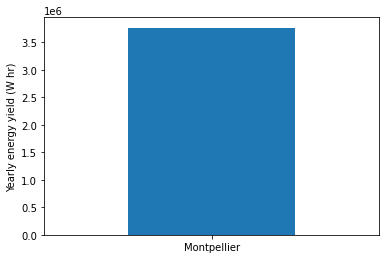

In [12]:
# Design PV OOP

from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    
    mount = FixedMount(surface_tilt=0.0, surface_azimuth=180.0)
    
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        modules_per_string=21,
        strings=1
    )
    
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    
    mc = ModelChain(system, location,
                    spectral_model='no_loss')  # on essaie spectral model = no loss...
    
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum()
    
    energies[name] = annual_energy

energies = pd.Series(energies)

energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')

In [13]:
print(f"{energies/1000}")

Montpellier    3768.911808
dtype: float64


In [14]:
# On va checker variable par variable

In [15]:
# Modèle PV Watts par heure

filename = "c:/Temp/results_pvwatts.csv"

results_pvwatts = pd.read_csv(filename, sep=";", header=15, nrows=8760) # dtype=dtype) #, converters=converters)

In [16]:
results_pvwatts

,Month,Day,Hour,Beam Irradiance (W/m^2),Diffuse Irradiance (W/m^2),Ambient Temperature (C),Wind Speed (m/s),Plane of Array Irradiance (W/m^2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,2.7,3.1,0.0,2.7,0.0,0.0
1,1,1,1,0,0,4.1,2.7,0.0,4.1,0.0,0.0
2,1,1,2,0,0,4.8,2.4,0.0,4.8,0.0,0.0
3,1,1,3,0,0,4.9,2.0,0.0,4.9,0.0,0.0
4,1,1,4,0,0,4.5,1.0,0.0,4.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,0,0,-0.3,3.1,0.0,-0.3,0.0,0.0
8756,12,31,20,0,0,-0.7,1.0,0.0,-0.7,0.0,0.0
8757,12,31,21,0,0,-0.7,1.0,0.0,-0.7,0.0,0.0
8758,12,31,22,0,0,-0.1,0.7,0.0,-0.1,0.0,0.0


In [17]:
results_pvwatts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Month                              8760 non-null   int64  
 1   Day                                8760 non-null   int64  
 2   Hour                               8760 non-null   int64  
 3   Beam Irradiance (W/m^2)            8760 non-null   int64  
 4   Diffuse Irradiance (W/m^2)         8760 non-null   int64  
 5   Ambient Temperature (C)            8760 non-null   float64
 6   Wind Speed (m/s)                   8760 non-null   float64
 7   Plane of Array Irradiance (W/m^2)  8760 non-null   float64
 8   Cell Temperature (C)               8760 non-null   float64
 9   DC Array Output (W)                8760 non-null   float64
 10  AC System Output (W)               8760 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 752.9 KB


In [18]:
# comparatif :

print(f"\nGlobal Irradiance:")
print(f"PV Watts : {results_pvwatts['Plane of Array Irradiance (W/m^2)'].sum()/1000:.0f} kWh/m²")  
print(f"MC : {mc.results.effective_irradiance.sum()/1000:.0f} kWh/m²")
print(f"PV-GIS : 1424 kWh/m²")

print(f"\nDC Output :")
print(f"PV Watts = {results_pvwatts['DC Array Output (W)'].sum()/1000:.0f} kWh")
print(f"MC = {mc.results.dc['p_mp'].sum()/1000:.0f} kWh")


Global Irradiance:
PV Watts : 1465 kWh/m²
MC : 957 kWh/m²
PV-GIS : 1424 kWh/m²

DC Output :
PV Watts = 10238 kWh
MC = 7150 kWh


In [19]:
weather['ghi'].sum()

1588805.9500000002

In [20]:
weather['dhi'].sum()

532691.25

In [21]:
weather['dni'].sum()

1890854.9

In [22]:
weather

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
utc_time,,,,,,,,,
2007-01-01 00:00:00+00:00,11.40,87.21,0.0,0.0,0.0,298.93,4.91,199.0,103456.0
2007-01-01 01:00:00+00:00,11.39,89.09,0.0,0.0,0.0,302.11,4.46,199.0,103409.0
2007-01-01 02:00:00+00:00,11.38,90.97,0.0,0.0,0.0,305.29,4.02,199.0,103362.0
2007-01-01 03:00:00+00:00,11.36,92.84,0.0,0.0,0.0,308.47,3.57,207.0,103312.0
2007-01-01 04:00:00+00:00,11.35,94.72,0.0,0.0,0.0,311.65,3.13,215.0,103262.0
...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00+00:00,11.45,77.83,0.0,0.0,0.0,283.03,7.14,324.0,102946.0
2012-12-31 20:00:00+00:00,11.44,79.71,0.0,0.0,0.0,286.21,6.69,324.0,102962.0
2012-12-31 21:00:00+00:00,11.43,81.59,0.0,0.0,0.0,289.39,6.25,324.0,102946.0
